Detecting Money Laundering: A Machine Learning Approach

In this project we trained several models to detect Money Laundering transactions. we have started 5 baseline models. Those are, LogisticRegression, KNeighborsClassifier, RandomForestClassifier, XGBClassifier, SupportVectorMachine Classifier. we continued to optimize top two models based on their train and test accuracy result. XGBoost and RandomForest Models. we have done five iterations including grid search on hyperparameters, balancing the labels by SMOTE and subsampling from the original dataset. Both RandomForest and XGBoost model had over 99% accuracy on the data that includes all frauds and some random safe data. The data was still imbalanced so I did SMOTE over this dataset as well. At the end of those iterations, XGBoost model had 99% Accuracy Score on both train and test sets. Accuracy score was calculated by computing Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

Dataset has fillowing columns:

Transaction ID  -  is a unique alphanumeric code that identifies a financial transaction.

Branch Name - a physical location of a bank that offers face-to-face services.Meanwhile where the account opend in this case. 

Transaction Date - the date when a transaction occurs.

Transaction Time - The transaction time-period is the time when a transaction is valid.

Transaction Type - are categories that help classify and understand transactions. (Deposit,Withdrawal & Transfer)

Conducting Manner - channels used to access the accounts (Account to Account, Cash, Internet Banking and Mobile Banking)

Old Balance Org - initial balance before the transaction

New Balance Orig - new balance after the transaction

Amount In Birr - amount of the transaction in local currency.

Sex - The customer Gender Female or Male

Birthday - The customer age

Occupation - The customer job or profession.

City - The customer home city

Sub City - The customer home Sub city

Account No - A bank account number is a unique set of digits assigned to the account when you open a bank account.

Account Type

Old Balance Dest - initial balance recipient before the transaction. 

Balance Held Dest - new balance recipient after the transaction.

is Fraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than ETB 300,000 (USD 15,000) in a single transaction.


Project Steps
1. Loading Data and EDA
2. Feature Engineering
3. Machine Learning
3.1.  Baseline Models
3.2.  Grid Search for Best Hyper-parameter
3.3.  Dealing with Unbalanced Data
3.3.1.  Balancing Data via Resambling with SMOTE
3.3.2.  Subsampling Data from the Original Dataset
3.3.3  Performing SMOTE on the New Data
4. Machine Learning Pipeline
5. Feature Importance
6. Conclusion
7. Future Works

1.Loading Data and EDA

In [1]:
import os
import math
from numpy import * 
import numpy as np
import pandas as pd
import random
import seaborn as sns #for visualization
import matplotlib.pyplot as plt #for visualization

In [2]:
#Load data 
data = pd.read_csv('C:\\Users\\Vostro 3568\\Desktop\\AML\\Money_Laundering_Dataset.csv')
data

,Transaction ID,Branch Name,Transaction Date,Transaction Time,Transaction Type,Conducting Manner,Old Balance Org,New Balance Orig,Amount in Birr,Sex,Birth Date,Occupation,Sub City,Account No,Account Type,Old Balance Held Dest,Balance Held Dest,is Fraud
0,TT23122ZS7W9;1,DARUSELAM BRANCH,02-05-23,11:38,CASH_OUT,Cash,15325.00,0.00,229133.94,MALE,03-02-96,TREADER,AWI,28023405.0,WADIAH CURRENT,5083.00,51513.44,0
1,TT23122NGHZK;1,BALDERAS CONDOMIN BR,02-05-23,16:24,TRANSFER,Cash,705.00,0.00,215310.30,MALE,04-02-90,UNEMPLOYED,ARADA,40108475.0,SAV INT BEARING,22425.00,0.00,0
2,TT23122HR4K1;1,DIRE DAWA BRANCH,02-05-23,9:18,TRANSFER,Cash,10835.00,0.00,311685.89,MALE,02-01-62,SELF EMPLOYED,DD,40958681.0,SPECIAL SAVINGS,6267.00,2719172.89,0
3,TT23122667PT;1,MINA BRANCH,02-05-23,16:57,CASH_OUT,Cash,26845.41,0.00,110414.71,MALE,03-02-78,SELF EMPLOYED,S/WOLLO,42354236.0,WADIAH SAVING,288800.00,2415.16,0
4,TT23122SR53Z;1,WOYIN WUHA BRANCH,02-05-23,8:17,CASH_OUT,Cash,1942.02,0.00,56953.90,MALE,03-02-85,Not Available,W/GOJJAM,46048954.0,SAV INT BEARING,70253.00,64106.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572191,FT231715BKJY;1,NEGUS SAHLESLASSIE BRA,30-09-23,11:43,CASH_OUT,Account to Account,107623.00,4231.07,103391.93,MALE,14-Feb-89,PRIVATE,DB,59843807.0,WADIAH SAVING,5752648.68,5856040.61,0
572192,FT231713CGHJ;1,NEGUS SAHLESLASSIE BRA,30-09-23,15:20,CASH_IN,Account to Account,41533.00,154945.53,113412.53,MALE,19-Mar-82,PRIVATE,NORTH SHOWA,36760575.0,WADIAH SAVING,565908.33,452495.80,0
572193,FT23171VLZP1;1,ADISHIM DHUN BRANCH,30-09-23,14:42,TRANSFER,Account to Account,15956.51,0.00,132387.24,MALE,03-Feb-84,NONE,DEBUB,54034806.0,SAV INT BEARING,631284.08,763671.32,0
572194,FT23171F144Q;1,SHEWA BER BRANCH,30-09-23,17:34,CASH_OUT,Account to Account,18002.85,0.00,279674.05,MALE,17-Mar-91,PERSONAL,JINELA,25603109.0,WADIAH SAVING,1847488.28,2127162.32,0


In [3]:
## Summary of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572196 entries, 0 to 572195
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Transaction ID         572196 non-null  object 
 1   Branch Name            572196 non-null  object 
 2   Transaction Date       572196 non-null  object 
 3   Transaction Time       572196 non-null  object 
 4   Transaction Type       572196 non-null  object 
 5   Conducting Manner      529509 non-null  object 
 6   Old Balance Org        572196 non-null  float64
 7   New Balance Orig       572196 non-null  float64
 8   Amount in Birr         572196 non-null  float64
 9   Sex                    566839 non-null  object 
 10  Birth Date             564985 non-null  object 
 11  Occupation             567945 non-null  object 
 12  Sub City               568497 non-null  object 
 13  Account No             572193 non-null  float64
 14  Account Type           572098 non-nu

In [4]:
## Finding null values
data.isna().sum()

Transaction ID               0
Branch Name                  0
Transaction Date             0
Transaction Time             0
Transaction Type             0
Conducting Manner        42687
Old Balance Org              0
New Balance Orig             0
Amount in Birr               0
Sex                       5357
Birth Date                7211
Occupation                4251
Sub City                  3699
Account No                   3
Account Type                98
Old Balance Held Dest        0
Balance Held Dest            0
is Fraud                     0
dtype: int64

Null Values are present and need to perform SimpleImputer Median for Numerical & Most_Frequent to categorical variable.

In [5]:
## Finding duplicates in Rows
data.duplicated().sum()

np.int64(0)

In [6]:
## Most_Frequent for convertinig null values for Categorical Variable

from sklearn.impute import SimpleImputer

# Separate the columns with missing values
missing_col1 = ['Conducting Manner', 'Sex', 'Birth Date','Occupation', 'Sub City' , 'Account Type']

# Create a KNN imputer object
imputer = SimpleImputer(strategy='most_frequent')

# Impute the missing values
data[missing_col1] = imputer.fit_transform(data[missing_col1])


In [7]:
## Using Median Simple Imputer to convert Null Values Present in Numericals

from sklearn.impute import SimpleImputer

# Separate the columns with missing values
missing_cols = ['Account No']

imputer = SimpleImputer(strategy='median')

# Impute the missing values
data[missing_cols] = imputer.fit_transform(data[missing_cols])

In [8]:
data.isna().sum()

Transaction ID           0
Branch Name              0
Transaction Date         0
Transaction Time         0
Transaction Type         0
Conducting Manner        0
Old Balance Org          0
New Balance Orig         0
Amount in Birr           0
Sex                      0
Birth Date               0
Occupation               0
Sub City                 0
Account No               0
Account Type             0
Old Balance Held Dest    0
Balance Held Dest        0
is Fraud                 0
dtype: int64

In [9]:
#examine the dataset
data.describe()

,Old Balance Org,New Balance Orig,Amount in Birr,Account No,Old Balance Held Dest,Balance Held Dest,is Fraud
count,5.721960e+05,5.721960e+05,5.721960e+05,5.721960e+05,5.721960e+05,5.721960e+05,572196.000000
mean,1.197986e+06,1.236970e+06,2.782937e+05,7.293919e+07,1.535555e+06,1.769501e+06,0.001596
std,3.453921e+06,3.504539e+06,3.114226e+05,1.116556e+08,2.739052e+06,2.858872e+06,0.039913
min,0.000000e+00,0.000000e+00,5.509117e+04,3.290000e+02,0.000000e+00,0.000000e+00,0.000000
25%,0.000000e+00,0.000000e+00,1.208090e+05,3.066429e+07,1.534622e+05,2.688294e+05,0.000000
50%,1.779800e+04,0.000000e+00,1.982596e+05,6.727429e+07,5.868437e+05,7.947679e+05,0.000000
75%,2.007973e+05,2.958836e+05,3.184571e+05,1.086463e+08,1.694951e+06,2.034224e+06,0.000000
max,3.860000e+07,3.890000e+07,1.000000e+07,9.696970e+09,4.210000e+07,4.220000e+07,1.000000


C:\Users\Vostro 3568\AppData\Local\Temp\ipykernel_21648\464657187.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Transaction Hour'])


Text(0.5, 1.0, 'Distribution of Transactions over the Time')

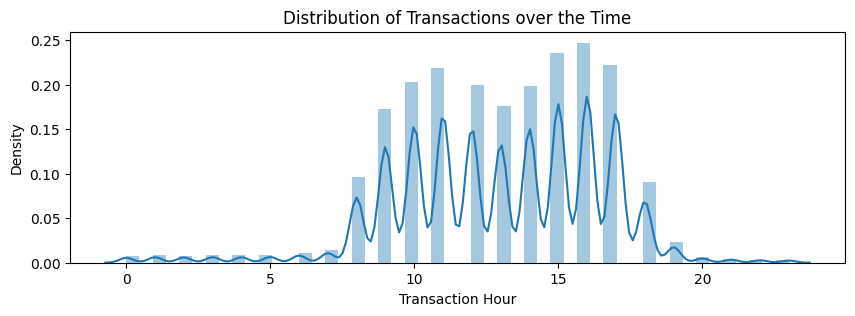

In [10]:
#Distribution of the frequency of all transactions

# Convert 'Transaction Time' to a 24-hour format
# Extract just the hour component from 'Transaction Time' without considering the minutes
data['Transaction Hour'] = pd.to_datetime(data['Transaction Time'], format='%H:%M').dt.hour

plt.figure(figsize=(10, 3))
sns.distplot(data['Transaction Hour'])
plt.title('Distribution of Transactions over the Time')


There are no duplicate rows, so we do not need to worry about duplicated data.

Examine the data by the labels
I will filter the data by the labels and examine two groups compairing each other.

In [11]:
# Filter data by the labels. Safe and Fraud transaction
safe = data[data['is Fraud']==0]
fraud = data[data['is Fraud']==1]

C:\Users\Vostro 3568\AppData\Local\Temp\ipykernel_21648\4083780402.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(safe['Transaction Hour'], label="Safe Transaction")
C:\Users\Vostro 3568\AppData\Local\Temp\ipykernel_21648\4083780402.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fraud[

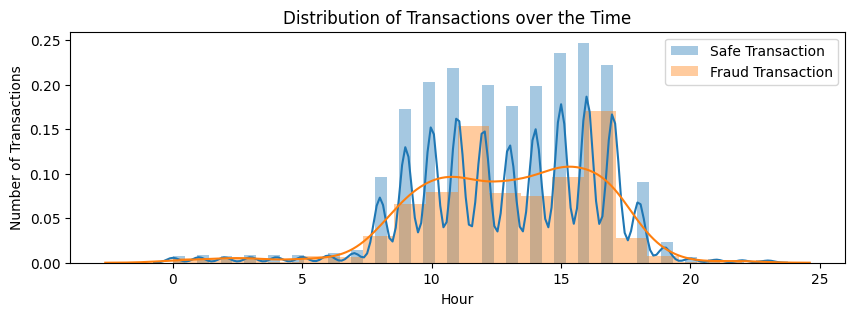

In [12]:
#See the frequency of the transactions for each class on the same plot.
plt.figure(figsize=(10, 3))
sns.distplot(safe['Transaction Hour'], label="Safe Transaction")
sns.distplot(fraud['Transaction Hour'], label="Fraud Transaction")
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Transactions over the Time')
plt.legend()

This fluctuation suggests that suspicious activities may coincide with times when legitimate transactions peak, indicating that malicious actors might time their actions strategically. 

Hourly Transaction Amounts

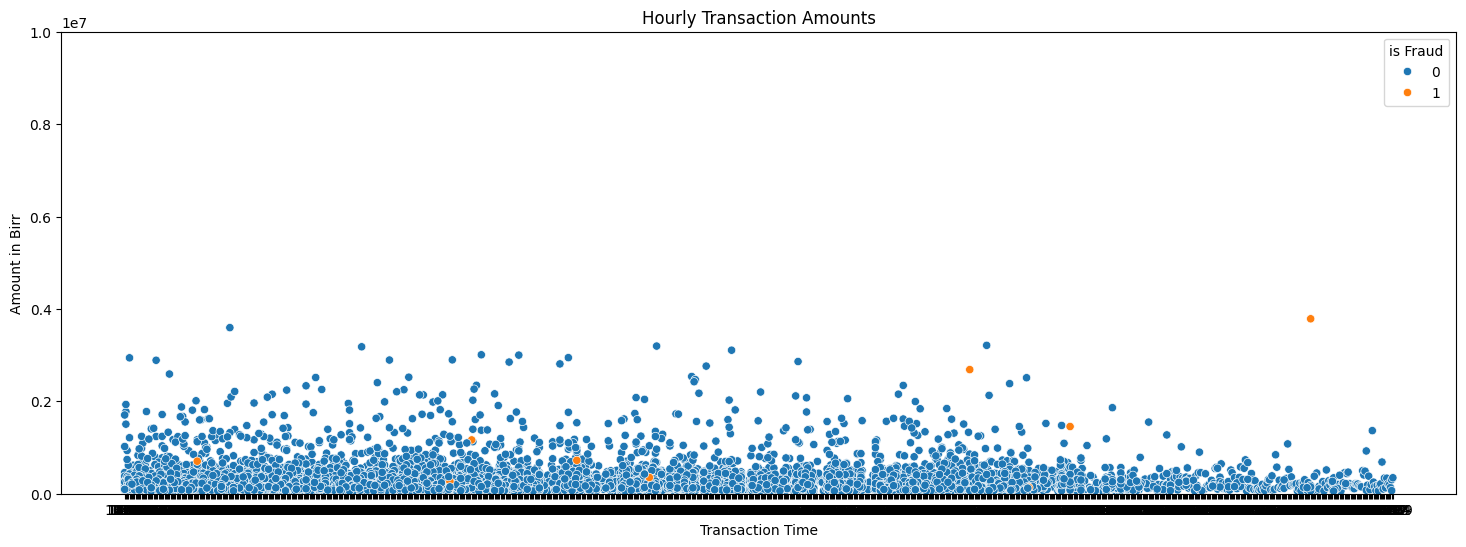

In [13]:
#just use small portion of data to scatterplot the transaction happens every hour and their amount. 
smalldata=data.sample(n=10000, random_state=1)
smalldata=smalldata.sort_index()
smalldata=smalldata.reset_index(drop=True)

#plot the small data
plt.figure(figsize=(18,6))
plt.ylim(0, 10000000)
plt.title('Hourly Transaction Amounts')
ax = sns.scatterplot(x="Transaction Time", y="Amount in Birr", hue="is Fraud",
                     data=smalldata)

The overall pattern shows that while the majority of transactions are relatively uniform and low, the fraudulent ones stand out as isolated instances above the typical range.

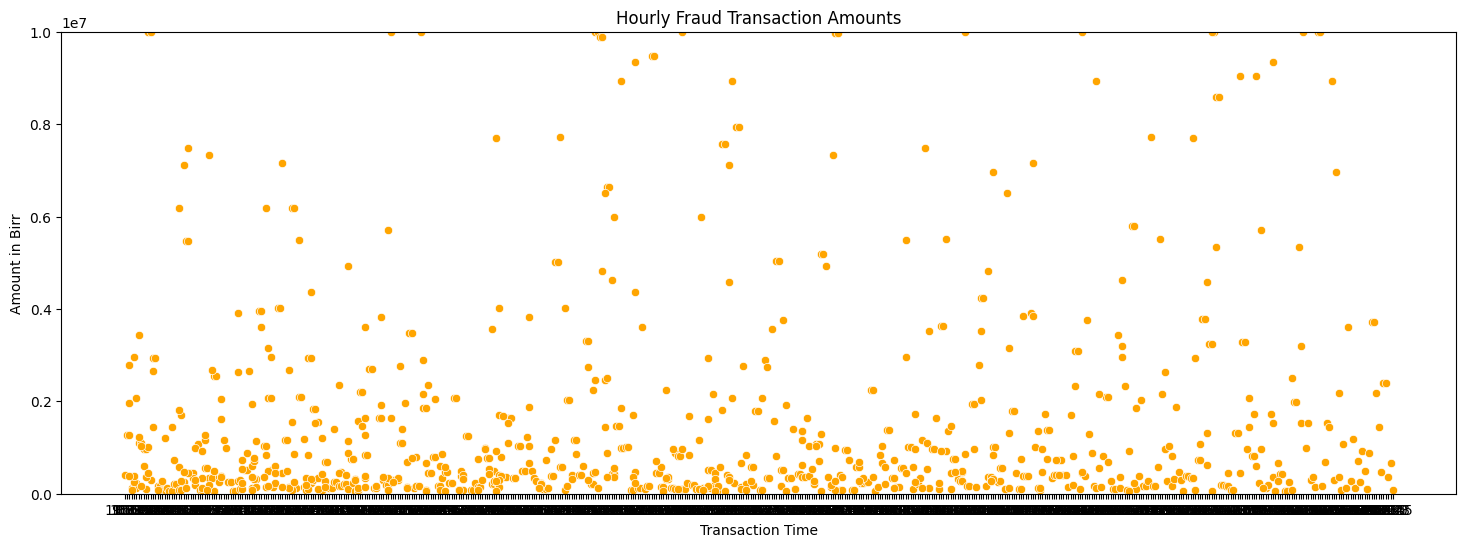

In [14]:
#The hourly amount of al fraud transactions
plt.figure(figsize=(18,6))
plt.ylim(0, 10000000)
plt.title('Hourly Fraud Transaction Amounts')
ax = sns.scatterplot(x="Transaction Time", y="Amount in Birr", color='orange',
                     data=fraud)

The plot displays hourly fraudulent transaction amounts in Birr, with all data points represented as orange dots. Most transactions cluster near zero, indicating low amounts, while a few scattered points reach higher values, highlighting significant fraudulent activities. This visual suggests that fraudulent transactions are relatively rare compared to the overall volume of transactions.

Transaction Amount Distributions

C:\Users\Vostro 3568\AppData\Local\Temp\ipykernel_21648\291028414.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(safe['Amount in Birr'])


<Axes: title={'center': 'Safe Transaction Amount Distribution'}, xlabel='Amount in Birr', ylabel='Density'>

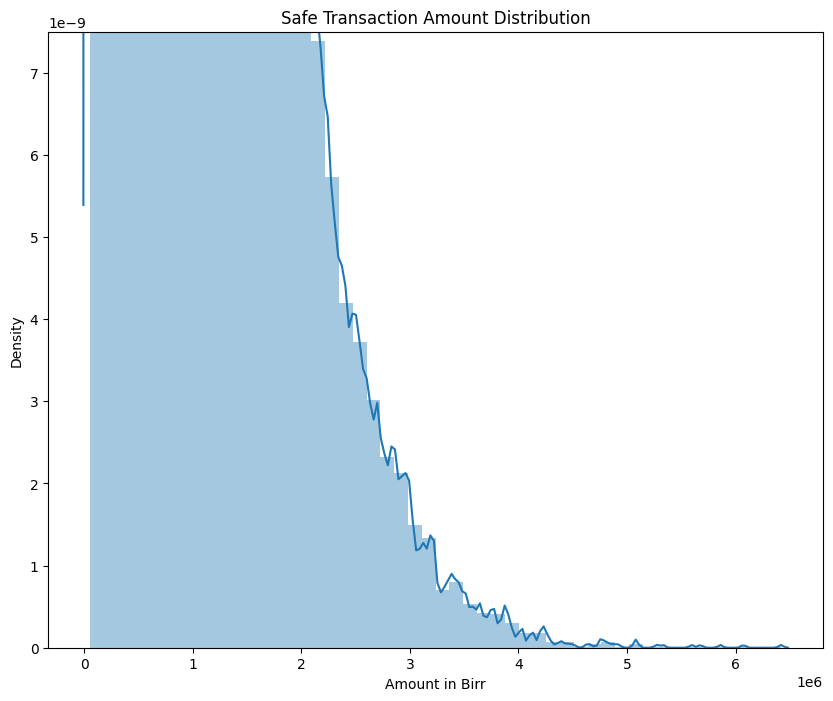

In [15]:
#safe transactions amount distribution plot
plt.figure(figsize=(10,8))
plt.ylim(0, 0.0000000075)
plt.title('Safe Transaction Amount Distribution')
sns.distplot(safe['Amount in Birr'])


The plot depicts the distribution of safe transaction amounts in Birr, displaying a steep decline in density as the transaction values increase. Most transactions are concentrated at lower amounts, with the density tapering off significantly beyond 2 million Birr, suggesting that higher-value transactions are quite rare. This pattern indicates a preference for lower transaction amounts within the safe transaction dataset.

In [16]:
safe['Amount in Birr'].describe()

count    5.712830e+05
mean     2.763633e+05
std      2.953898e+05
min      5.509117e+04
25%      1.207597e+05
50%      1.981101e+05
75%      3.180355e+05
max      6.419835e+06
Name: Amount in Birr, dtype: float64

The summary statistics reveal that the safe transaction amounts have a mean of approximately 276,363 Birr, with a notable standard deviation of 295,389 Birr, indicating significant variation within the dataset, while the amounts range from a minimum of about 55,091 Birr to a maximum of 6,419,835 Birr.

C:\Users\Vostro 3568\AppData\Local\Temp\ipykernel_21648\3638505062.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fraud['Amount in Birr'])


<Axes: title={'center': 'Fraud Transaction Amount Distribution'}, xlabel='Amount in Birr', ylabel='Density'>

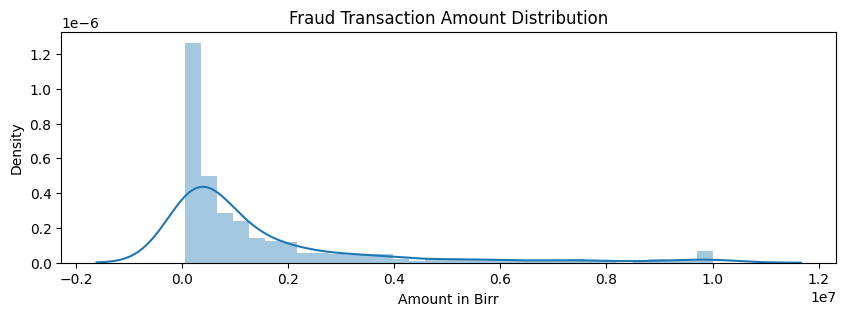

In [17]:
# Fraud transactions amount distribution plot
plt.figure(figsize=(10,3))
plt.title('Fraud Transaction Amount Distribution')
sns.distplot(fraud['Amount in Birr'])

The plot illustrates the distribution of fraudulent transaction amounts in Birr, showing a significant peak at lower transaction values, which indicates that most fraudulent activities are concentrated around these amounts. The density gradually decreases, with very few transactions reaching higher values, suggesting that high-value fraudulent transactions are particularly rare. Overall, the distribution highlights a skew towards smaller fraud amounts, with a long tail extending towards larger values.

In [18]:
# fraud transactions amount value counts
fraud['Amount in Birr'].value_counts()

Amount in Birr
10000000.00    14
216422.00       2
87999.25        2
56745.14        2
1277212.77      2
               ..
149668.66       1
222048.71       1
454859.39       1
132842.64       1
416001.33       1
Name: count, Length: 462, dtype: int64

The value counts for fraudulent transaction amounts indicate that the most common amount is 10,000,000 Birr, appearing 14 times, while a variety of other amounts appear less frequently, with many transactions occurring just once. This suggests that while there are numerous unique fraud amounts, a small number of them dominate the dataset, particularly the large transaction of 10,000,000 Birr. The presence of multiple unique amounts could indicate diverse fraudulent activities within different value ranges.

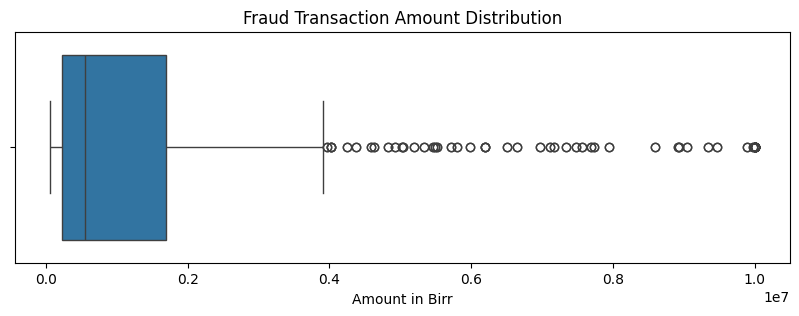

In [19]:
#Fraud transaction boxplot for amount distribution
plt.figure(figsize=(10,3))
plt.title('Fraud Transaction Amount Distribution')
ax = sns.boxplot(x=fraud["Amount in Birr"])

The box plot illustrates the distribution of fraudulent transaction amounts, revealing a significant concentration of values within the interquartile range (IQR) from approximately 0 to 400,000 Birr. Several outliers extend beyond the upper whisker, indicating a few exceedingly high fraudulent transactions, with the maximum amount approaching 10 million Birr. This highlights the occurrence of rare, large-scale frauds amidst a larger number of smaller fraudulent activities.

In [20]:
fraud['Amount in Birr'].describe()

count    9.130000e+02
mean     1.486201e+06
std      2.174481e+06
min      5.674514e+04
25%      2.220487e+05
50%      5.562180e+05
75%      1.698264e+06
max      1.000000e+07
Name: Amount in Birr, dtype: float64

The summary statistics for fraudulent transaction amounts indicate a mean of approximately 1,486,201 Birr, with a high standard deviation of 2,174,481 Birr, reflecting considerable variability in transaction sizes. The values range from a minimum of about 56,745 Birr to a maximum of 10,000,000 Birr, suggesting there are both small and exceptionally large fraudulent transactions within the dataset. The quartile values further demonstrate that the majority of fraud occurs in the lower ranges, while high-value transactions, although fewer, significantly impact the average.

In [21]:
#average amount for frauds below 400K
fraud[fraud['Amount in Birr']<400000]['Amount in Birr'].mean()

np.float64(199473.28747368424)

The average amount for fraudulent transactions below 400,000 Birr is approximately 199,473 Birr. This indicates that while there are some high-value fraud cases, the typical amount for lower-value fraudulent transactions is significantly less, highlighting a different scale of fraudulent activity within this range.

Type of Transactions

In [23]:
#checking Conducting Manner of  safe transactions
safe['Conducting Manner'].value_counts()

Conducting Manner
Account to Account    302197
Cash                  220769
Internet Banking       36450
Mobile Banking         11867
Name: count, dtype: int64

In [24]:
#checking Conducting Manner of fraud transactions
fraud['Conducting Manner'].value_counts()


Conducting Manner
Account to Account    666
Cash                  150
Internet Banking       87
Mobile Banking         10
Name: count, dtype: int64

Rate of Fraud Transactions

In [25]:
#proportion of number of frauds 
data ['is Fraud'].value_counts()[1]/(data ['is Fraud'].value_counts()[0]+data ['is Fraud'].value_counts()[1])


np.float64(0.0015956070996651498)

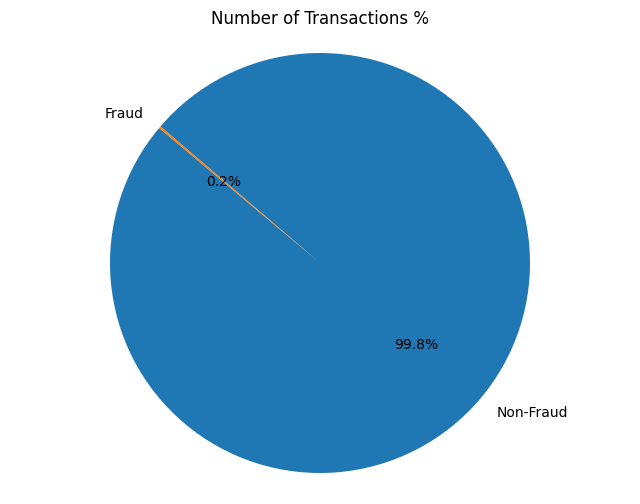

In [26]:
# Assuming `data` is your DataFrame and 'isFraud' is the target column
fraud_counts = data['is Fraud'].value_counts()
labels = ['Non-Fraud', 'Fraud']
sizes = [fraud_counts[0], fraud_counts[1]]
# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#1f77b4','#ff7f0e'])
plt.title('Number of Transactions %')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

The pie chart highlights the stark contrast between fraudulent and non-fraudulent transactions, with fraud comprising just 0.2% of the total transactions. This indicates that the vast majority, 99.8%, of transactions are legitimate, underscoring the rarity of fraud within the dataset. The visualization effectively emphasizes the overwhelming prevalence of non-fraudulent activities relative to fraudulent ones.

In [27]:
#proportion of fraud amount
fraud['Amount in Birr'].sum()/(safe['Amount in Birr'].sum()+fraud['Amount in Birr'].sum())

np.float64(0.008521189076551824)

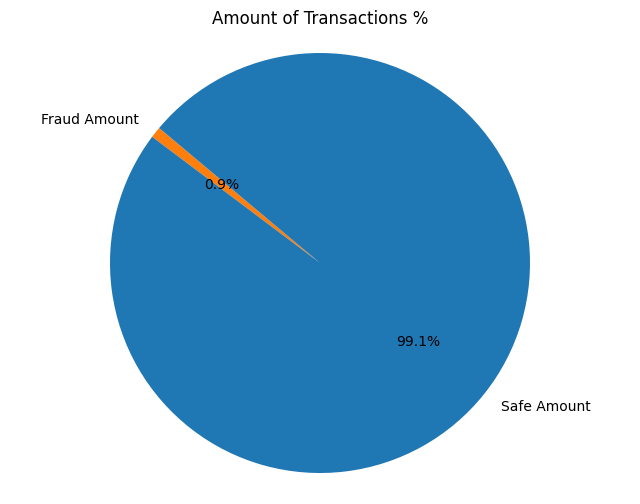

In [28]:
# Assuming `fraud` and `safe` are DataFrames with the appropriate amounts
fraud_amount = fraud['Amount in Birr'].sum()
safe_amount = safe['Amount in Birr'].sum()

# Calculate proportions
total_amount = fraud_amount + safe_amount
proportions = [fraud_amount, safe_amount]
labels = ['Fraud Amount', 'Safe Amount']
import matplotlib.pyplot as plt

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(proportions, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff7f0e', '#1f77b4'])
plt.title('Amount of Transactions %')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

The pie chart visually conveys that fraudulent transactions account for only 0.9% of the total amount, while safe transactions dominate at 99.1%. This stark disparity highlights the rarity of fraud compared to legitimate transactions, emphasizing the overall integrity of the dataset. The clear distinction between the two categories reinforces the effectiveness of fraud detection measures in identifying outliers.

is Fraud column

Lets examine the is Fraud column.

In [29]:
#value counts of is Fraud column
data['is Fraud'].value_counts()

is Fraud
0    571283
1       913
Name: count, dtype: int64

In [30]:
#there are only 913 positive value. lets see which ones they are. 
data[data['is Fraud']==1]

,Transaction ID,Branch Name,Transaction Date,Transaction Time,Transaction Type,Conducting Manner,Old Balance Org,New Balance Orig,Amount in Birr,Sex,Birth Date,Occupation,Sub City,Account No,Account Type,Old Balance Held Dest,Balance Held Dest,is Fraud,Transaction Hour
312,TT23122YLFR9;1,JIJIGA BRANCH,02-05-23,11:33,CASH_OUT,Cash,0.00,0.0,416001.33,MALE,05-04-90,SELF EMPLOYED,FAFEN,109320153.0,SAV INT BEARING,102.00,9291619.62,1,11
396,TT23122H0B74;1,SARIS BRANCH,02-05-23,9:39,TRANSFER,Cash,1277212.77,0.0,1277212.77,MALE,02-01-98,PRIVATE,GULELE,111866503.0,AFLA SAVING,0.00,0.00,1,9
397,TT2312240RSG;1,TULU BOLO BRANCH,02-05-23,16:09,CASH_OUT,Cash,1277212.77,0.0,1277212.77,MALE,03-02-75,PRIVATE,SOUTH WEST SHOA,110752709.0,SAV INT BEARING,0.00,2444985.19,1,16
677,TT23122MQ2ZX;1,GENDE KORE BRANCH,02-05-23,10:37,CASH_OUT,Cash,4499.08,0.0,132842.64,MALE,01-01-76,SELF,BALE ROBE,133894225.0,WADIAH SAVING,0.00,132842.64,1,10
807,TT23122BPFN4;1,CHEFE DONSA BRANCH,02-05-23,15:29,TRANSFER,Cash,235238.66,0.0,235238.66,MALE,04-02-64,Private,BALE ROBE,102211917.0,BALEWUL SAVING,0.00,0.00,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571341,FT23171YRPQ8;1,TELE MEDHANEALEM BR,30-09-23,14:27,CASH_OUT,Account to Account,655676.97,0.0,655676.97,MALE,26-Jul-70,BUSINESS MAN,BOLE,11694427.0,SAV INT BEARING,53614.28,709291.25,1,14
572028,FT231717M6MK;1,ADAGO BRANCH,30-09-23,17:05,TRANSFER,Account to Account,56745.14,0.0,56745.14,MALE,06-Mar-54,Private,NORTH WOLLO,100944391.0,SAV INT BEARING,0.00,0.00,1,17
572029,FT231712CML7;1,DJZ TESHOME SHNKUT BR,30-09-23,16:40,CASH_OUT,Account to Account,56745.14,0.0,56745.14,MALE,02-Jan-87,GOVERNMENT,N/SHOA,25420896.0,SAV INT BEARING,51433.88,108179.02,1,16
572147,FT23171P19QQ;1,WELETE BRANCH,30-09-23,15:33,TRANSFER,Account to Account,87999.25,0.0,87999.25,MALE,18-Mar-90,Private,SPECIAL,79786322.0,Fitayah Savings,0.00,0.00,1,15


2. Feature Engineering

Binary encoding the type column

In [32]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder for categorical features
label_encoder = LabelEncoder()

# List of object columns to encode (excluding Transaction ID)
columns_to_encode = [
    'Branch Name', 'Transaction Type', 'Conducting Manner', 'Sex',
    'Occupation', 'Sub City', 'Account Type'
]

# Apply Label Encoding to each column in the list
for col in columns_to_encode:
    data[col] = label_encoder.fit_transform(data[col])



Lets drop the Account No colums since it is senseative information. 

In [34]:
#drop the name columns
data = data.drop(['Account No' , 'Transaction ID'], axis=1)
data

,Branch Name,Transaction Date,Transaction Time,Transaction Type,Conducting Manner,Old Balance Org,New Balance Orig,Amount in Birr,Sex,Birth Date,Occupation,Sub City,Account Type,Old Balance Held Dest,Balance Held Dest,is Fraud,Transaction Hour
0,259,02-05-23,11:38,1,1,15325.00,0.00,229133.94,1,03-02-96,5171,1703,67,5083.00,51513.44,0,11
1,161,02-05-23,16:24,4,1,705.00,0.00,215310.30,1,04-02-90,5258,1417,46,22425.00,0.00,0,16
2,303,02-05-23,9:18,4,1,10835.00,0.00,311685.89,1,02-01-62,4368,2881,50,6267.00,2719172.89,0,9
3,651,02-05-23,16:57,1,1,26845.41,0.00,110414.71,1,03-02-78,4368,8390,68,288800.00,2415.16,0,16
4,849,02-05-23,8:17,1,1,1942.02,0.00,56953.90,1,03-02-85,2804,9570,46,70253.00,64106.18,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572191,672,30-09-23,11:43,1,0,107623.00,4231.07,103391.93,1,14-Feb-89,3345,2874,68,5752648.68,5856040.61,0,11
572192,672,30-09-23,15:20,0,0,41533.00,154945.53,113412.53,1,19-Mar-82,3345,7861,68,565908.33,452495.80,0,15
572193,50,30-09-23,14:42,4,0,15956.51,0.00,132387.24,1,03-Feb-84,2670,2960,46,631284.08,763671.32,0,14
572194,762,30-09-23,17:34,1,0,18002.85,0.00,279674.05,1,17-Mar-91,3029,5314,68,1847488.28,2127162.32,0,17


Lets Convert 'Transaction Date' and 'Transaction Time' to datetime and Convert 'Birth Date' to datetime and extract age

In [35]:
# Convert 'Transaction Date' and 'Transaction Time' to datetime
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], errors='coerce')
data['Transaction Time'] = pd.to_datetime(data['Transaction Time'], errors='coerce')

# Extract features from 'Transaction Date' and 'Transaction Time'
data['Transaction Day'] = data['Transaction Date'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
data['Transaction Hour'] = data['Transaction Time'].dt.hour  # Hour of the day (0-23)

# Drop the original 'Transaction Date' and 'Transaction Time' after extracting features
data = data.drop(columns=['Transaction Date', 'Transaction Time'])

# Convert 'Birth Date' to datetime and extract age
data['Birth Date'] = pd.to_datetime(data['Birth Date'], errors='coerce')

# Ensure that any invalid dates (like '02-01-85') are properly handled
data['Age'] = (pd.to_datetime('today') - data['Birth Date']).dt.days // 365  # Age in years
data = data.drop(columns=['Birth Date'])  # Drop the original 'Birth Date' column

C:\Users\Vostro 3568\AppData\Local\Temp\ipykernel_21648\2417239607.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], errors='coerce')
C:\Users\Vostro 3568\AppData\Local\Temp\ipykernel_21648\2417239607.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Transaction Time'] = pd.to_datetime(data['Transaction Time'], errors='coerce')
C:\Users\Vostro 3568\AppData\Local\Temp\ipykernel_21648\2417239607.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Birth Date'] = pd.to_datetime(data['Birth Date

3. Machine Learning

In [36]:
from sklearn.model_selection import train_test_split # import train_test_split function
from sklearn.linear_model import LogisticRegression # import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score # import accuracy metrics
from sklearn.ensemble import RandomForestClassifier #import RandomForestClassifier
from sklearn import svm  #import support vector machine classifier
import xgboost as xgb  
from xgboost import  XGBClassifier  #import xgboost classifier 
from sklearn.neighbors import KNeighborsClassifier #import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV # import GridSearchCV
from sklearn.preprocessing import LabelEncoder
# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [37]:
# Assuming your dataframe data has been defined
# Slice the target and features from the dataset

features = data.drop('is Fraud', axis=1)
target = data['is Fraud']

# If there are categorical columns, encode them
for col in features.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    features[col] = le.fit_transform(features[col])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# List to store the results
results = []


3.1. Baseline Models

First, We will run five classification model with their default parameter to see how each one perform. we will put all the classifers into a list and train them in a loop. ml_func function handles all train, evaluation and storing the performence metrics. Also, the data is highly unbalanced, the positive class (frauds) account for 0.01% of all transactions. So I will be measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [38]:
# General function to run classifier with default parameters to get baseline model
def ml_func(algoritm):
    # Train and fit regression model
    model = algoritm()
    model.fit(X_train, y_train)

    # Predict
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Evaluate
    train_accuracy = roc_auc_score(y_train, train_preds)
    test_accuracy = roc_auc_score(y_test, test_preds)

    # Print results
    print(str(algoritm))
    print("------------------------")
    print(f"Training Accuracy: {(train_accuracy * 100):.4}%")
    print(f"Test Accuracy:     {(test_accuracy * 100):.4}%")

    # Append the results to the list
    results.append([algoritm.__name__, train_accuracy, test_accuracy])

In [39]:
# List of all classifiers to run for base models
algorithms = [LogisticRegression, KNeighborsClassifier, RandomForestClassifier, XGBClassifier, svm.SVC]

# Running each model and print accuracy scores
for algorithm in algorithms:
    ml_func(algorithm)

# Convert the list of results to a DataFrame
models_df = pd.DataFrame(results, columns=['Algorithm', 'Training Accuracy', 'Test Accuracy'])

# Display the DataFrame with model results
print(models_df)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
------------------------
Training Accuracy: 73.34%
Test Accuracy:     70.69%
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
------------------------
Training Accuracy: 84.43%
Test Accuracy:     83.61%
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
------------------------
Training Accuracy: 100.0%
Test Accuracy:     84.48%
<class 'xgboost.sklearn.XGBClassifier'>
------------------------
Training Accuracy: 99.26%
Test Accuracy:     87.64%
<class 'sklearn.svm._classes.SVC'>
------------------------
Training Accuracy: 63.19%
Test Accuracy:     62.35%
                Algorithm  Training Accuracy  Test Accuracy
0      LogisticRegression           0.733362       0.706853
1    KNeighborsClassifier           0.844322       0.836058
2  RandomForestClassifier           1.000000       0.844814
3           XGBClassifier           0.992558       0.876380
4                     SVC           0.631931       0.6235

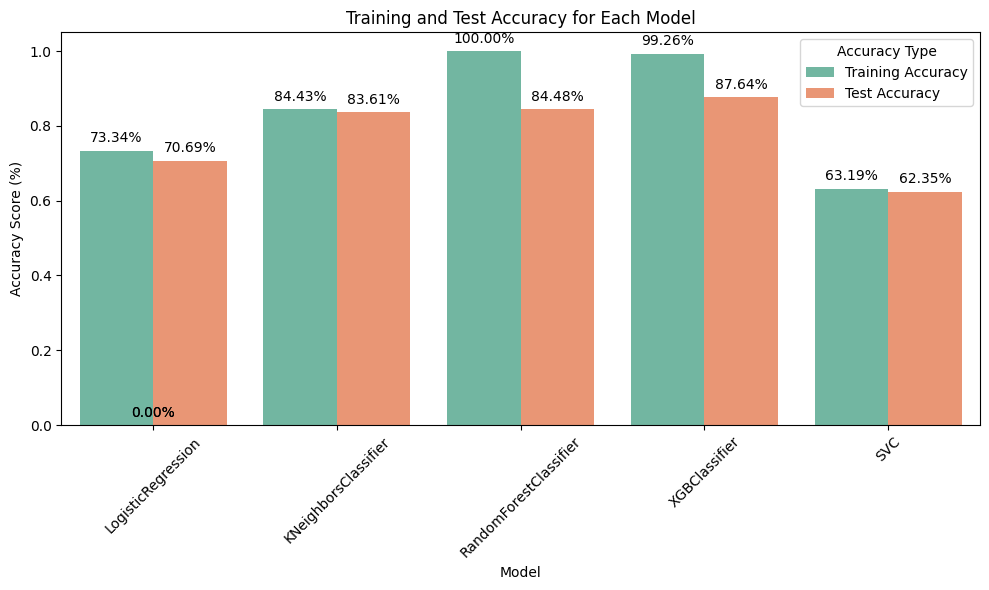

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'models_df' DataFrame has already been created from your previous code

# Plot the Training and Test Accuracy using a bar plot
plt.figure(figsize=(10, 6))

# Melt the DataFrame to make it easier to plot
models_df_melted = pd.melt(models_df, id_vars='Algorithm', value_vars=['Training Accuracy', 'Test Accuracy'], 
                           var_name='Accuracy Type', value_name='Accuracy Score')

# Create the bar plot using seaborn
barplot = sns.barplot(x='Algorithm', y='Accuracy Score', hue='Accuracy Type', data=models_df_melted, palette='Set2')

# Adding labels and title
plt.title('Training and Test Accuracy for Each Model')
plt.xlabel('Model')
plt.ylabel('Accuracy Score (%)')
plt.xticks(rotation=45)
plt.legend(title='Accuracy Type')

# Add accuracy score percentages on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height() * 100, '.2f') + '%', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), textcoords = 'offset points')

# Show the plot
plt.tight_layout()
plt.show()


3.2. Grid Search for Best Hyper-Parameter

In the above report we see the best training accuracy is from Random Forest Classifier. On the other hand the best test accuracy is from XGBoost Classifier. We would like to optimize these two model with grid search of multiple parameter values. Grid earch will help me to figure our best parameters to pass to the model to get the most accurate result. We will create a function for grid search named best_param. It will take parameter values and the classifer and print our the best parameter combinations. We will only run Random Forest and XGBoost models for the rest of the project since they are the best two.



In [41]:
#A general function for grdi search
from sklearn.model_selection import train_test_split, GridSearchCV
def grid_src(classifier, param_grid):
    param_grid=param_grid
    # instantiate the tuned random forest
    grid_search = GridSearchCV(classifier, param_grid, cv=3, n_jobs=-1)

    # train the tuned random forest
    grid_search.fit(X_train, y_train)

    # print best estimator parameters found during the grid search
    print((str(classifier) + 'Best Parameters'))
    print("------------------------")
    print(grid_search.best_params_)
    return grid_search.best_params_

In [42]:
#Grid Search for best parameters of RandomForestClassifier
param_grid_rf = {'n_estimators': [10, 80, 100],
                  'criterion': ['gini', 'entropy'],         
                  'max_depth': [10], 
                  'min_samples_split': [2, 3, 4]
                 }

rf_params=grid_src(RandomForestClassifier(),param_grid_rf)

RandomForestClassifier()Best Parameters
------------------------
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 80}


In [43]:
#Grid Search for best parameters of XGBClassifier
param_grid_xg = {'n_estimators': [100],
              'learning_rate': [0.05, 0.1], 
              'max_depth': [3, 5, 10],
              'colsample_bytree': [0.7, 1],
              'gamma': [0.0, 0.1, 0.2]
                }

grid_src(XGBClassifier(), param_grid_xg)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)Best Parameters
------------------------
{'colsample_bytree': 1, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}


{'colsample_bytree': 1,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 100}

Run models with their best parameters

In [44]:
#a function to train and evaluate a  model with given datasets 
#it also prints the accuracy scores 
from sklearn.metrics import roc_auc_score, classification_report
def run_model(model, X_train, y_train,X_test, y_test ):
    model.fit(X_train, y_train)

    # predict
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # evaluate
    train_accuracy = roc_auc_score(y_train, train_preds)
    test_accuracy = roc_auc_score(y_test, test_preds)
    report = classification_report(y_test, test_preds)

    #print reports of the model accuracy
    print('Model Scores')
    print("------------------------")
    print(f"Training Accuracy: {(train_accuracy * 100):.4}%")
    print(f"Test Accuracy:     {(test_accuracy * 100):.4}%")
    print("------------------------------------------------------")
    print('Classification Report : \n', report)

In [45]:
# Running RandomForestClassifier with best parameters
rf_model=RandomForestClassifier(n_estimators=100, 
                                  criterion= 'gini', 
                                  max_depth= 10, 
                                  min_samples_split= 3)
                               
                               
run_model(rf_model, X_train, y_train,X_test, y_test)

Model Scores
------------------------
Training Accuracy: 83.36%
Test Accuracy:     82.47%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    114266
           1       0.98      0.65      0.78       174

    accuracy                           1.00    114440
   macro avg       0.99      0.82      0.89    114440
weighted avg       1.00      1.00      1.00    114440



The accuracy dropped because I set max_depth to 10. This is kind of cut off for the model to stop after that point. The result with defauul value is higher because it goes unlimited until all leaves are the purist level. But it will take too long for a big dataset. I will keep this parameter and try to improve.



In [46]:
# Running XGBClassifier with best parameters
xgb_model=XGBClassifier(colsample_bytree= 1, 
                        n_estimators= 100,
                        gamma= 0.1,
                        learning_rate=0.1,
                        max_depth=5
                        )
                                                                 
run_model(xgb_model, X_train, y_train,X_test, y_test)

Model Scores
------------------------
Training Accuracy: 87.28%
Test Accuracy:     86.2%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    114266
           1       0.95      0.72      0.82       174

    accuracy                           1.00    114440
   macro avg       0.97      0.86      0.91    114440
weighted avg       1.00      1.00      1.00    114440



XGBoost definetely works better with the best parameters set.

Randomforest classifier might be effected the skewness of the target. Our data is quite unbalanced. That skewness can be taken care by resampling the data via SMOTE.

3.3. Dealing with Unbalanced Data

3.3.1. Balancing Data via Oversampling with SMOTE

In [47]:
from imblearn.over_sampling import SMOTE

# View previous class distribution
print(target.value_counts()) 

# Resample data ONLY using training data
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train) 

# View synthetic sample class distribution
print(pd.Series(y_resampled).value_counts())


is Fraud
0    571283
1       913
Name: count, dtype: int64
is Fraud
0    457017
1    457017
Name: count, dtype: int64


In [48]:
# perform  train-test-split over resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

Running models with the balanced data with best parameters

In [49]:
#Running RainForest Model with resampled data
run_model(rf_model, X_train, y_train,X_test, y_test)

Model Scores
------------------------
Training Accuracy: 99.01%
Test Accuracy:     98.92%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    114504
           1       0.98      1.00      0.99    114005

    accuracy                           0.99    228509
   macro avg       0.99      0.99      0.99    228509
weighted avg       0.99      0.99      0.99    228509



In [50]:
#Running XGBoost Model with resampled data
run_model(xgb_model, X_train, y_train,X_test, y_test)

Model Scores
------------------------
Training Accuracy: 99.64%
Test Accuracy:     99.6%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    114504
           1       0.99      1.00      1.00    114005

    accuracy                           1.00    228509
   macro avg       1.00      1.00      1.00    228509
weighted avg       1.00      1.00      1.00    228509



The performence increased dramatically for both models. Having almost 100% accuracy is suspicious though. It is probably because of the synthetic data that SMOTE created. Since there are only small amount of instances for fraud class, it created too many of the same data. Model memorize that pattern and gives perfect result on the test set. Because, there is highly possible that same data points are also availble in the test set.

3.3.2. Subsampling Data from the Original Dataset

I had a huge dataset at the beginning and I did random sampling to reduce the computational laod. But I have a lot more natural fraud data point in this dataset that I can use. Insted of creating syntetic data I will choose those pints and randomly choose the safe transaction data points to get less skewed sample for my models.

In [51]:
# Slice data into fraud and safe by isFraud values
safe_2 = data[data['is Fraud'] == 0]
fraud_2 = data[data['is Fraud'] == 1]

# Get 50,000 random samples from the safe transactions
safe_sample = safe_2.sample(n=50000, random_state=1)
safe_sample = safe_sample.sort_index()
safe_samplef = safe_sample.reset_index(drop=True)

# Combine all fraud observations and 50,000 safe transaction data into df3
df3 = pd.concat([safe_sample, fraud_2])
df3.reset_index(drop=True)

df3.head()


,Branch Name,Transaction Type,Conducting Manner,Old Balance Org,New Balance Orig,Amount in Birr,Sex,Occupation,Sub City,Account Type,Old Balance Held Dest,Balance Held Dest,is Fraud,Transaction Hour,Transaction Day,Age
9,297,4,1,0.0,0.0,77957.68,1,3746,2881,46,94900.0,22233.65,0,10,6,40
13,402,4,1,0.0,0.0,379856.23,1,2804,2017,46,900180.0,19200000.00,0,14,6,42
14,151,4,1,0.0,0.0,1505626.01,1,3345,5981,19,29031.0,5515763.34,0,18,6,35
53,583,1,1,0.0,0.0,114712.48,1,3225,7463,46,145400.0,0.00,0,9,6,31
61,335,1,1,0.0,0.0,80311.89,1,4627,4451,46,87408.0,63112.23,0,11,6,32


In [52]:
#check class labels
df3['is Fraud'].value_counts()

is Fraud
0    50000
1      913
Name: count, dtype: int64

The new dataset with totally natural data is ready for going in to our models. The proportion is still not 50% but good enough to train a model.

Running models with subsampled organic data


In [54]:
#Slice the target and features from the dataset
features2=df3.drop('is Fraud', axis=1)
target2 =df3['is Fraud']
# split the data into train and test
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, test_size=0.2)

In [55]:
# Running RandomForestClassifier with best parameters
run_model(rf_model, X_train2, y_train2,X_test2, y_test2)

Model Scores
------------------------
Training Accuracy: 87.5%
Test Accuracy:     87.03%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9998
           1       1.00      0.74      0.85       185

    accuracy                           1.00     10183
   macro avg       1.00      0.87      0.92     10183
weighted avg       1.00      1.00      0.99     10183



In [74]:
# Running XGBClassifier with best parameters

run_model(xgb_model, X_train2, y_train2,X_test2, y_test2)


Model Scores
------------------------
Training Accuracy: 96.69%
Test Accuracy:     92.78%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9981
           1       0.95      0.86      0.90       202

    accuracy                           1.00     10183
   macro avg       0.97      0.93      0.95     10183
weighted avg       1.00      1.00      1.00     10183



The results look much realistic. I can still use SMOTE on this new dataset and see how it effects the results now. But XGBoost model seems to be working clearly better in any set of data so far. Eventhough we have better proportion we still have unbalanced data. We can permofm oversampling on this new data to have more fraud data.


3.3.3 Performing SMOTE on the New Data

In [56]:
from imblearn.over_sampling import SMOTE

# view previous class distribution
print(target2.value_counts()) 

# resample data ONLY using training data
X_resampled2, y_resampled2 = SMOTE().fit_resample(X_train2, y_train2) 


# view synthetic sample class distribution
print(pd.Series(y_resampled2).value_counts()) 
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, test_size=0.2)

is Fraud
0    50000
1      913
Name: count, dtype: int64
is Fraud
0    40002
1    40002
Name: count, dtype: int64


Running models with subsampled and oversampled data

In [57]:
# Running RandomForestClassifier with best parameters
run_model(rf_model, X_train2, y_train2,X_test2, y_test2)

Model Scores
------------------------
Training Accuracy: 87.25%
Test Accuracy:     84.24%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      9980
           1       1.00      0.68      0.81       203

    accuracy                           0.99     10183
   macro avg       1.00      0.84      0.90     10183
weighted avg       0.99      0.99      0.99     10183



In [58]:

# Running XGBClassifier with best parameters
run_model(xgb_model, X_train2, y_train2,X_test2, y_test2)

Model Scores
------------------------
Training Accuracy: 96.82%
Test Accuracy:     91.09%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9980
           1       0.95      0.82      0.88       203

    accuracy                           1.00     10183
   macro avg       0.98      0.91      0.94     10183
weighted avg       1.00      1.00      1.00     10183



XGBoost improved a little bit more but Random Forest accuracy decreased with this new data. I can say that Random Forest can not handling too many repeted data for the sake of balancing

4. Machine Learning Pipeline

Pipelines are extremely useful tools to write clean and manageable code for machine learning.Creating a model takes a many steps such as clean our data, transform it, potentially use feature selection, and then run a machine learning algorithm. Using pipelines, we can do all these steps in one go!

In [59]:
#Load necessary libraries for ml pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [60]:
# Create the pipeline
pipe = Pipeline([('scl', MinMaxScaler()),
                ('pca', PCA(n_components=7)),
                ('xgb', XGBClassifier())])

# Create the grid parameter
grid = [{'xgb__n_estimators': [100],
         'xgb__learning_rate': [0.05, 0.1], 
         'xgb__max_depth': [3, 5, 10],
         'xgb__colsample_bytree': [0.7, 1],
         'xgb__gamma': [0.0, 0.1, 0.2]
                }]
                                 
# Create the grid, with "pipe" as the estimator
gridsearch = GridSearchCV(estimator=pipe,
                  param_grid=grid,
                  scoring='accuracy',
                  cv=3)

# Fit using grid search
gridsearch.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gridsearch.best_score_)

# Best params
print('\nBest params:\n', gridsearch.best_params_)

Best accuracy: 0.946

Best params:
 {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100}


The model achieved a best accuracy of 94.6%, indicating strong predictive performance. The optimal parameters include a maximum depth of 10, a learning rate of 0.1, and 100 estimators, with a full column sample and no gamma regularization, suggesting a robust configuration for the XGBoost algorithm.

5. Feature Importance

Lets check whick features are the most influencial ones for both model.

In [61]:
# Check the number of features in the model and the DataFrame
print(f"Number of features in model: {len(rf_model.feature_importances_)}")
print(f"Number of columns in features DataFrame: {len(features.columns)}")

Number of features in model: 15
Number of columns in features DataFrame: 15


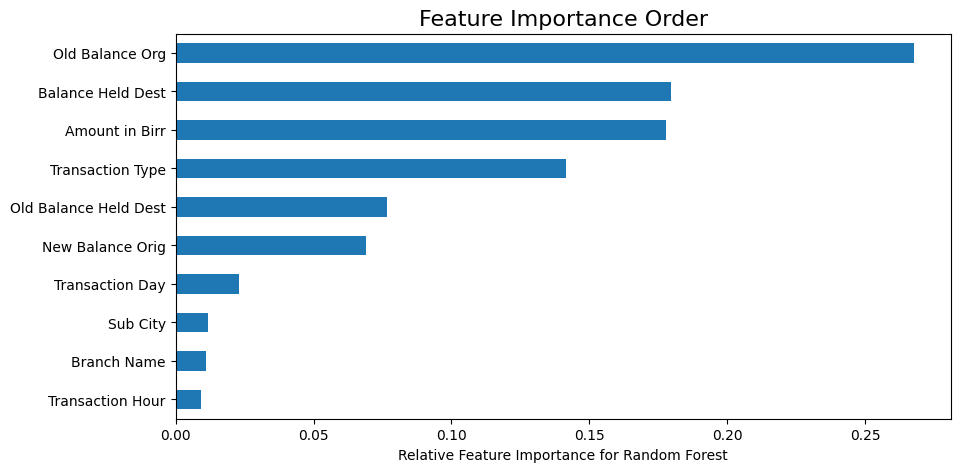

In [62]:
# Identify the columns used for training the model
model_features = features.columns[:15]  # Adjust this if the extra column is not the last one

# Remove the extra column from the features DataFrame
features = features[model_features]

# plot the important features - based on Random Forest
feat_importances = pd.Series(rf_model.feature_importances_, index=features.columns)
ax.set_ylabel('features', size = 16);
feat_importances.nlargest(10).sort_values().plot(kind='barh', figsize=(10,5))
plt.xlabel('Relative Feature Importance for Random Forest');
plt.title('Feature Importance Order', size = 16);

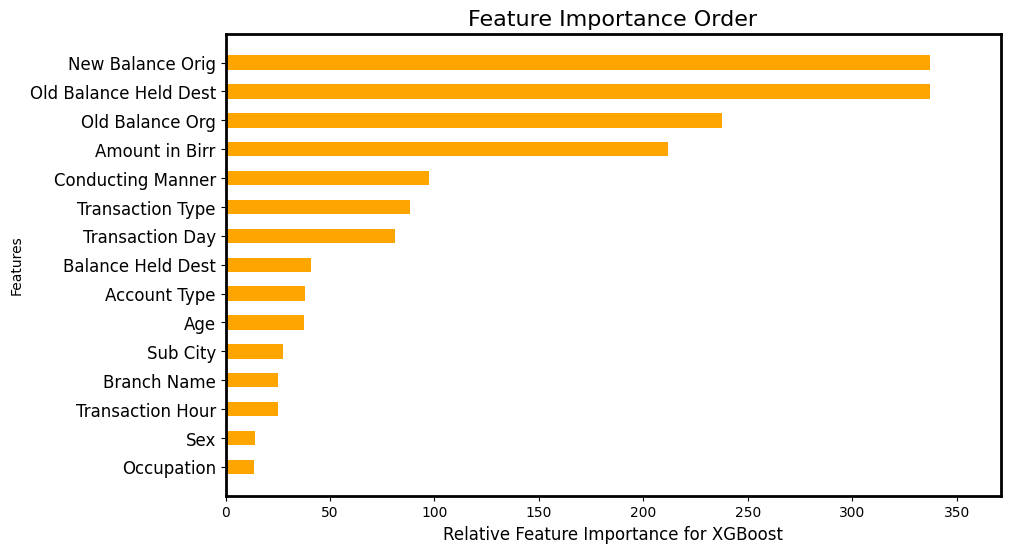

In [63]:
# plot the important features - based on XGBOOST
from xgboost import plot_importance

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
colours = plt.cm.Set1(np.linspace(0, 1, 9))
ax = plot_importance(xgb_model, height = 0.5, color = 'orange', grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)        
ax.set_xlabel('Relative Feature Importance for XGBoost', size=12);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Feature Importance Order', size = 16);

The feature importance chart for XGBoost indicates that "New Balance Orig" is the most influential feature in predicting outcomes, followed closely by "Old Balance Held Dest" and "Old Balance Org." These findings suggest that balance-related features play a critical role in the model's decision-making process, highlighting the importance of financial figures in the dataset. This insight can guide further analysis or model refinement by focusing on these key features.

6. Conclusion

Accuracy results after iterations

We created a model that can predict fraud transactions. We used XGBoost and RandomForest classifiers in this model.

  (Data & Parameters)                                                (Accuracy)   
                                                             RandomForest     XGBoost

  **Iteration 1**                                                            
- Random Sample & default parameters                                84.48%    87.64%               
 **Iteration 2** 
- Random Sample & best parameters                                   82.47%     86.2%
  **Iteration 3**
- Balanced data with SMOTE & best parameters                        98.92%     99.6% 
  **Iteration 4**
- Random Safe trans. data and all Fraud data & best parameters      87.03%     92.78%
  **Iteration 5**
- New data balanced with SMOTE & best parameters                    94.24%     91.09%

Performence has increased after five iterations and finally reached to;

99% accuracy with XGBoost Classifier and Balanced Data

Most Influential Features
Most important features are senders balance before the transaction (Old Balance Orig) and receivers balance after the transaction (New Balance Dest).

7.Future Work

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import pickle

# Define your pipeline
pipe = Pipeline([('scl', MinMaxScaler()),
                 ('pca', PCA(n_components=7)),
                 ('xgb', XGBClassifier())])

# Define your grid of hyperparameters
grid = [{'xgb__n_estimators': [100],
         'xgb__learning_rate': [0.05, 0.1], 
         'xgb__max_depth': [3, 5, 10],
         'xgb__colsample_bytree': [0.7, 1],
         'xgb__gamma': [0.0, 0.1, 0.2]
        }]

# Perform GridSearchCV
gridsearch = GridSearchCV(estimator=pipe, param_grid=grid, scoring='accuracy', cv=3)

# Fit the grid search to your training data
gridsearch.fit(X_train, y_train)

# Extract the best model
best_model = gridsearch.best_estimator_

# Save the best model to a file
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print('Model saved successfully.')


Model saved successfully.


In [ ]:
import pickle
import numpy as np

# Load the model from the file
with open('best_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Make predictions
predictions = loaded_model.predict(X_test)

# Assuming you have defined the trained classifier 'classifier'

input_data = [
    212, 4, 4953893.08, 4953893.08, 4953893.08, 0.0, 00.00, 1
]

# Convert non-numeric values to a consistent format (e.g., '0' or 0)
processed_data = []
for value in input_data:
    if isinstance(value, str) and not value.isnumeric():
        processed_data.append(0)
    else:
        processed_data.append(value)

# Convert the processed data to a numpy array
input_data_as_numpy_array = np.asarray(processed_data)

# Reshape the numpy array as we are predicting for only one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1, -1)

# Make prediction using the loaded model
prediction = loaded_model.predict(input_data_reshaped)
print(prediction)

# Interpret the result
if prediction[0] == 0:
    print('Not a fraudulent transaction')
else:
    print('Fraudulent transaction')


In [ ]:

# Perform predictions on the test set
y_pred = best_model.predict(X_test)

# If you need the probability estimates, you can use:
# y_proba = best_model.predict_proba(X_test)

# Print the first few predictions (for demonstration purposes)
print('Predictions:\n', y_pred[:100])

# Optionally, print the predicted probabilities for the first few samples
# print('Predicted Probabilities:\n', y_proba[:10])


In [ ]:
import pickle

with open('best_model.pkl', 'rb') as file:
    content = pickle.load(file)
    print(type(content))
    print(content)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import pickle

# Example data preparation
# X_train, y_train, X_test, y_test should be defined

# Create the pipeline
pipe = Pipeline([
    ('scl', MinMaxScaler()),
    ('pca', PCA(n_components=7)),
    ('xgb', XGBClassifier())
])

# Create the grid parameter
grid = [{'xgb__n_estimators': [100],
         'xgb__learning_rate': [0.05, 0.1], 
         'xgb__max_depth': [3, 5, 10],
         'xgb__colsample_bytree': [0.7, 1],
         'xgb__gamma': [0.0, 0.1, 0.2]
        }]

# Create the grid search
gridsearch = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          scoring='accuracy',
                          cv=3)

# Fit using grid search
gridsearch.fit(X_train, y_train)

# Print best accuracy and parameters
print('Best accuracy: %.3f' % gridsearch.best_score_)
print('\nBest params:\n', gridsearch.best_params_)

# Get the best model from the grid search
best_model = gridsearch.best_estimator_

# Get predicted probabilities for the positive class
y_probs = best_model.predict_proba(X_test)[:, 1]

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# Calculate and print average precision score
average_precision = average_precision_score(y_test, y_probs)
print(f'Average Precision Score: {average_precision:.2f}')


In [ ]:
import pickle

# Assuming gridsearch is your GridSearchCV object
best_model = gridsearch.best_estimator_

# Save the best model to a file
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)


In [ ]:
import pickle

# Load the saved model
with open('best_model.pkl', 'rb') as file:
    content = pickle.load(file)

# Check the type of the content
print(type(content))  # Should be <class 'sklearn.pipeline.Pipeline'> or similar




In [ ]:
print(loaded_model.named_steps)  # Shows the steps in the pipeline

In [ ]:
from xgboost import XGBClassifier

# Updated initialization for XGBoost v1.3.0+
model = XGBClassifier(
    colsample_bytree=0.7,
    gamma=0.0,
    learning_rate=0.1,
    max_depth=10,
    n_estimators=100,
    objective='binary:logistic',
    random_state=42
)
